In [1]:
import pickle
import pandas as pd
from p05_nlp import display_topics
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import HBox, Label, IntSlider, FloatSlider
from ipywidgets import Button, Layout

In [3]:
from PIL import Image
import requests
from io import BytesIO

In [4]:
with open("df_all_cleaned.pickle", "rb") as read_file:
    df_all = pickle.load(read_file)

In [5]:
with open("df_topics.pickle", "rb") as read_file:
    df_topics = pickle.load(read_file)

In [6]:
with open("reviews_nmf_df.pickle", "rb") as read_file:
    reviews_nmf_df = pickle.load(read_file)

In [7]:
with open("nmf_topics.pickle", "rb") as read_file:
    topic_labels = pickle.load(read_file)

In [8]:
with open("nmf_components.pickle", "rb") as read_file:
    nmf_components = pickle.load(read_file)

In [9]:
with open("reviews_feature_names_nmf.pickle", "rb") as read_file:
    topic_contents = pickle.load(read_file)

In [10]:
display_topics(nmf_components, topic_contents, num_top_words=15, topic_names=topic_labels)


Topic: ' Art/Classic '
french, art, cinema, war, image, camera, leave, experience, book, beautiful, dream, woman, mind, documentary, reality

Topic: ' Gory/Scary '
horror, gore, slasher, halloween, house, scary, killer, scare, craven, creepy, murr, blood, kill, effect, ghost

Topic: ' Sci Fi '
alien, sci_fi, planet, space, science, ear, ship, effect, mars, fiction, robot, spaceship, special, scientist, budget

Topic: ' Vampires '
vampire, dracula, horror, hammer, blood, count, carmilla, cushing, castle, martin, nosferatu, helse, kronos, sarandon, susan

Topic: ' Silly '
comedy, funny, laugh, joke, humor, hilarious, gag, fun, sketch, python, funniest, guy, stupid, monty_python, humour

Topic: ' Animated '
animation, animate, anime, disney, cartoon, cat, fritz, voice, japanese, ralph, ult, animated, wizard, fantasy, rabbit

Topic: ' Martial Arts '
martial, kung_fu, fight, action, kong, art, hong, dragon, chinese, japanese, master, chow, fighting, tournament, fighter

Topic: ' Music Docu

You entered: Shaun of the Dead


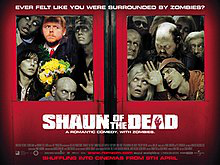

In [18]:
# create text box to receive input movie
btn_layout = Layout(width='20%', height='29px')
gen_btn = Button(description='Generate', layout=btn_layout)
# rec_btn = Button(description='Recommend', layout=btn_layout)

text_layout = Layout(width='50%')
movie_title = widgets.Text(placeholder='Enter a movie title', description='Title:', 
                           layout=text_layout, disabled=False)
display(HBox([movie_title, gen_btn]))

def movie_info(movie_title):
    title = movie_title.value
    print("You entered: {}".format(title))
    url = 'https://' + list(df_all[df_all['title']==title]['poster_url'])[0]
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    display(img)
    
def on_gen_btn_clicked(gen_btn):
    movie_info(movie_title)
    
gen_btn.on_click(on_gen_btn_clicked)

In [29]:
# generate sliders based on input movie's topic distribution dictionary
title_mask = df_topics['title']==movie_title.value
dict_in = df_topics[title_mask].iloc[:,1:].to_dict('list') 
sliders={}
float_text={}
style = {'description_width': '150px'}
sliders_layout = {'width': '60%'}
float_text_layout = {'width': '70px'}
for key, val in dict_in.items():
    value = val[0]*100
    sliders[key] = widgets.FloatSlider(value=value, min=0.0, max=100.0, 
                                       readout_format='.2f', description=key,
                                       style=style, layout=sliders_layout)
    float_text[key] = widgets.FloatText(value=value, step='0.01', layout=float_text_layout)
    display(HBox([sliders[key], float_text[key]]))

links = {}
for key, val in dict_in.items():
    links[key] = widgets.jslink((float_text[key], 'value'), (sliders[key], 'value'))

In [30]:
# get recommended movies
sliders_dict = {}
topics = list(dict_in.keys())
for top in topics:
    sliders_dict[top] = [sliders[top].value/100]

def topic_levels(dict_in):
    '''
    Generates a list of top 5 most similar movies based on topic distribution from sliders.
    Does not include the input movie used to generate sliders.
    'Similarity' column indicates similarity to the sliders, not to the input movie.
    '''
    # create df_in from dict_in
    df_in = pd.DataFrame.from_dict(dict_in)
    topics = df_in.columns
    # get slice of df_topics
    df_slice = df_topics.loc[~title_mask,topics]
    # do cosine similarity
    movie_sim = cosine_similarity(df_slice,df_in)
    # get recommendations
    movie_rec = pd.concat([df_all['title'],pd.DataFrame(movie_sim)], axis=1)
    movie_rec.rename(columns={'title':'title', 0:'similarity'}, inplace=True)
    #return list of movies
    return movie_rec.sort_values(by='similarity',ascending=False).head(5)

pd.set_option('display.max_colwidth', -1)
recommended = topic_levels(sliders_dict)
display(recommended)

,title,similarity
199,Braindead,0.947799
1229,The Return of the Living Dead,0.947115
515,Fido,0.946370
1669,Zodiac,0.909248
362,Day of the Dead,0.906806
